In [33]:
import imaplib
import email
from email.header import decode_header
import webbrowser
import os
import re
from pymongo import MongoClient
import psycopg2
from psycopg2 import sql

# Fetch all emails up to date

In [34]:
username = "xxxxxxx@gmail.com"
app_password = 'wlzx uunw klyv aqsn'
mongodb_ip = '132.170.253.50'
mongodb_password = 'xxxxxxxxxxx'

In [76]:
# Connect to the PostgreSQL server
conn = psycopg2.connect(
    dbname="ainbox",
    user="postgres",
    password="xxxxxxxx",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

In [77]:
# Function to insert email into PostgreSQL
def insert_email(email_data):
    insert_query = sql.SQL("""
    INSERT INTO emails (email_id, subject, sender, recipients, cc, bcc, date, body_plain, links)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
    ON CONFLICT (id, email_id) DO UPDATE 
    SET
        subject = EXCLUDED.subject,
        sender = EXCLUDED.sender,
        recipients = EXCLUDED.recipients,
        cc = EXCLUDED.cc,
        bcc = EXCLUDED.bcc,
        date = EXCLUDED.date,
        body_plain = EXCLUDED.body_plain,
        links = EXCLUDED.links;
    """)
    cur.execute(insert_query, email_data)
    conn.commit()

In [78]:
# Function to decode email content with fallback
def decode_email_content(content, encoding):
    try:
        if isinstance(content, bytes):
            return content.decode(encoding or 'utf-8')
    except UnicodeDecodeError:
        try:
            return content.decode('latin-1')
        except UnicodeDecodeError:
            return content.decode('ascii', errors='ignore')


In [79]:
# Connect to Gmail's IMAP server
mail = imaplib.IMAP4_SSL("imap.gmail.com")
mail.login(username, app_password)

('OK', [b'jyubaeng@gmail.com authenticated (Success)'])

In [80]:
# Select the mailbox you want to use
mail.select("inbox")

# Search for all emails in the inbox
status, messages = mail.search(None, "ALL")

# Convert messages to a list of email IDs
email_ids = messages[0].split()

In [81]:
# Iterate through each email
for email_id in email_ids:
    # Fetch the email by ID
    status, msg_data = mail.fetch(email_id, "(RFC822)")
    for response_part in msg_data:
        if isinstance(response_part, tuple):
            msg = email.message_from_bytes(response_part[1])
            subject, encoding = decode_header(msg["Subject"])[0]
            if isinstance(subject, bytes):
                subject = decode_email_content(subject, encoding)
            from_ = msg.get("From")
            to_ = msg.get("To")
            cc_ = msg.get("Cc")
            bcc_ = msg.get("Bcc")
            date_ = msg.get("Date")

            # Parse the date
            if date_:
                date_ = email.utils.parsedate_to_datetime(date_)

            # Process email parts
            body_plain = ""
            if msg.is_multipart():
                for part in msg.walk():
                    content_type = part.get_content_type()
                    content_disposition = str(part.get("Content-Disposition"))
                    if content_type == "text/plain" and "attachment" not in content_disposition:
                        body_plain = decode_email_content(part.get_payload(decode=True), part.get_content_charset())
                        break
            else:
                body_plain = decode_email_content(msg.get_payload(decode=True), msg.get_content_charset())

            # Extract links
            links = []
            if body_plain:
                links = re.findall(r'(https?://\S+)', body_plain)

            # Prepare email data for insertion
            email_data = (
                email_id.decode(),
                subject,
                from_,
                [recipient.strip() for recipient in to_.split(',')] if to_ else [],
                [recipient.strip() for recipient in cc_.split(',')] if cc_ else [],
                [recipient.strip() for recipient in bcc_.split(',')] if bcc_ else [],
                date_,
                body_plain,
                links
            )

            # Insert email into PostgreSQL
            insert_email(email_data)

In [58]:
# Close the connection and logout
mail.close()
mail.logout()

# Close the database connection
cur.close()
conn.close()

# Run Kafka Server

- Configuration setting
    - server.properties: log.dirs=C:/Users/jyuba/kafka/kafka-logs
    - zookeeper.properties: dataDir=C:/Users/jyuba/kafka/zookeeper-data


- Run servers
    - Run zookeeper: .\bin\windows\zookeeper-server-start.bat .\config\zookeeper.properties
    - Run Kafka: .\bin\windows\kafka-server-start.bat .\config\server.properties

- Create topic & producer function & consumer function
    - Note: Go to windows folder
    - kafka-topics.bat --create --bootstrap-server localhost:9092 --topic test
    - kafka-console-producer.bat --broker-list localhost:9092 --topic test
    - kafka-console-consumer.bat --topic test --bootstrap-server localhost:9092 --from-beginning

# Create a topic in Kafka

In [59]:
from confluent_kafka.admin import AdminClient, NewTopic

In [68]:
# Kafka configuration
kafka_config = {
    'bootstrap.servers': 'localhost:9092'
}

# Create AdminClient
admin_client = AdminClient(kafka_config)

# Create a new topic
topic_name = 'emails'
num_partitions = 1
replication_factor = 1
new_topic = NewTopic(topic_name, num_partitions, replication_factor)

# Create topic
fs = admin_client.create_topics([new_topic])

In [75]:
# Check for operation to finish
for topic, f in fs.items():
    try:
        f.result()  # The result itself is None
        print(f"Topic {topic} created")
    except Exception as e:
        if "TOPIC_ALREADY_EXISTS" not in str(e):
            print(f"Failed to create topic {topic}: {e}")
        else:
            print(f"Topic {topic} already exists")

Topic emails already exists


# Develop Kafka Procedure

- Install Kafka and configure setting for Window
- Turn on Zookeeper / Kafka server and test producer/consumer on console
- Create a topic on Kafka
- Develop a producer to receive data from the App to the topic
- Develop a consumer to receive data from the topic and store it to the DB (I used Postgres)
- Develop a manager to run producer / consumer on background
- Run the manager
- Generate data on the app and confirm data is populated on the DB in 5 secs 

## Requirements:
1.	You must use at least 2 of the components you’ve learned (e.g., HDFS, YARN, Hive, HBase, Spark, Kafka, Solr, NiFi).
2.	Document your data source.
3.	Describe the operations or transformations you performed on the data.
4.	Explain why you chose to use the components you did.
5.	Include screenshots of the data usage across all the components you used.
6.	Your report should be at least 2 pages in length.


In [80]:
from pyspark.sql import SparkSession
import logging

In [81]:
# Initialize logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [82]:
# Path to your PostgreSQL JDBC driver
jdbc_driver_path = r"C:\Users\jyuba\postgresql-42.7.2.jar"  # Update this path

In [83]:
# Initialize Spark session
try:
    spark = SparkSession.builder \
        .appName("Postgres to Spark DataFrame") \
        .config("spark.jars", jdbc_driver_path) \
        .getOrCreate()
    logger.info("Spark Session created successfully.")
except Exception as e:
    logger.error(f"Error creating Spark Session: {e}")
    raise

INFO:__main__:Spark Session created successfully.


In [88]:
# PostgreSQL connection properties
jdbc_url = "jdbc:postgresql://localhost:5432/ainbox"  # Update with your actual JDBC URL
table = "emails"  # Update with your actual table name
properties = {
    "user": "postgres",
    "password": "xxxxxxxxxx",
    "driver": "org.postgresql.Driver"
}

In [90]:
# Read data from PostgreSQL table into a Spark DataFrame
try:
    df = spark.read.jdbc(url=jdbc_url, table=table, properties=properties)
    logger.info("Data read successfully from PostgreSQL.")
except Exception as e:
    logger.error(f"Error reading data from PostgreSQL: {e}")
    raise

INFO:__main__:Data read successfully from PostgreSQL.


# Exploratory Data Analysis

In [96]:
# Show the schema of the DataFrame
df.printSchema()


root
 |-- id: integer (nullable = true)
 |-- email_id: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- sender: string (nullable = true)
 |-- recipients: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cc: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- bcc: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: timestamp (nullable = true)
 |-- body_plain: string (nullable = true)
 |-- links: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [97]:
# Show the first few rows of the DataFrame
df.show(5, truncate=False)

+----+--------+-------------------------------------------------------------------------------------------------+--------------------------------------------------------------+--------------------+---+---+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [98]:
# Describe the DataFrame to get basic statistics
df.describe().show()

+-------+------------------+------------------+------------------------+--------------------+--------------------+
|summary|                id|          email_id|                 subject|              sender|          body_plain|
+-------+------------------+------------------+------------------------+--------------------+--------------------+
|  count|              2753|              2753|                    2753|                2753|                2753|
|   mean|1949.4998183799491|1377.0014529604068|                    NULL|                NULL|                NULL|
| stddev|1110.8626859641813| 794.8694870551872|                    NULL|                NULL|                NULL|
|    min|                 1|                 1|    \r\n \r\n \r\n \r...|"Academia.edu Mem...|                    |
|    max|              3565|               999|🫖🍵다다茶茶👩🏻‍🍳🥗...|opentutorialsorg@...|🚀﻿🚀 SQL Data En...|
+-------+------------------+------------------+------------------------+--------------------

In [99]:
# Count the number of rows
df.count()

2753

In [100]:
# Count distinct senders
df.select("sender").distinct().count()

253

In [101]:
# Count the number of emails per sender
df.groupBy("sender").count().orderBy("count", ascending=False).show(10, truncate=False)

+------------------------------------------------------------+-----+
|sender                                                      |count|
+------------------------------------------------------------+-----+
|Twitter <info@twitter.com>                                  |275  |
|"X (formerly Twitter)" <info@twitter.com>                   |246  |
|LinkedIn <updates-noreply@linkedin.com>                     |214  |
|"Facebook" <reminders@facebookmail.com>                     |202  |
|LinkedIn <messages-noreply@linkedin.com>                    |179  |
|Etsy <email@email.etsy.com>                                 |155  |
|LinkedIn <notifications-noreply@linkedin.com>               |147  |
|Bernard Marr via LinkedIn <newsletters-noreply@linkedin.com>|87   |
|"noreply.pncalerts@pnc.com" <pncalerts@pnc.com>             |84   |
|LinkedIn <jobs-listings@linkedin.com>                       |77   |
+------------------------------------------------------------+-----+
only showing top 10 rows



In [103]:
# Analyzing Dates
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, hour

# Extract year, month, day, and hour from the date column
df = df.withColumn("year", year("date"))
df = df.withColumn("month", month("date"))
df = df.withColumn("day", dayofmonth("date"))
df = df.withColumn("day_of_week", dayofweek("date"))
df = df.withColumn("hour", hour("date"))

In [104]:
# Count emails by year
df.groupBy("year").count().orderBy("year").show()

+----+-----+
|year|count|
+----+-----+
|2023| 1736|
|2024| 1017|
+----+-----+



In [105]:
# Count emails by month
df.groupBy("month").count().orderBy("month").show()

+-----+-----+
|month|count|
+-----+-----+
|    1|  128|
|    2|  187|
|    3|  250|
|    4|  419|
|    5|  403|
|    6|  206|
|    7|  204|
|    8|  280|
|    9|  248|
|   10|  175|
|   11|  140|
|   12|  113|
+-----+-----+



In [106]:
# Count emails by day of the week
df.groupBy("day_of_week").count().orderBy("day_of_week").show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|          1|  247|
|          2|  477|
|          3|  399|
|          4|  474|
|          5|  436|
|          6|  432|
|          7|  288|
+-----------+-----+



In [107]:
# Count emails by hour of the day
df.groupBy("hour").count().orderBy("hour").show()

+----+-----+
|hour|count|
+----+-----+
|   0|   93|
|   1|  133|
|   2|  100|
|   3|   44|
|   4|   36|
|   5|   32|
|   6|   29|
|   7|  113|
|   8|   82|
|   9|  129|
|  10|  146|
|  11|  144|
|  12|  139|
|  13|  146|
|  14|  128|
|  15|  121|
|  16|  110|
|  17|   70|
|  18|  132|
|  19|  338|
+----+-----+
only showing top 20 rows



In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame
pdf = df.toPandas()

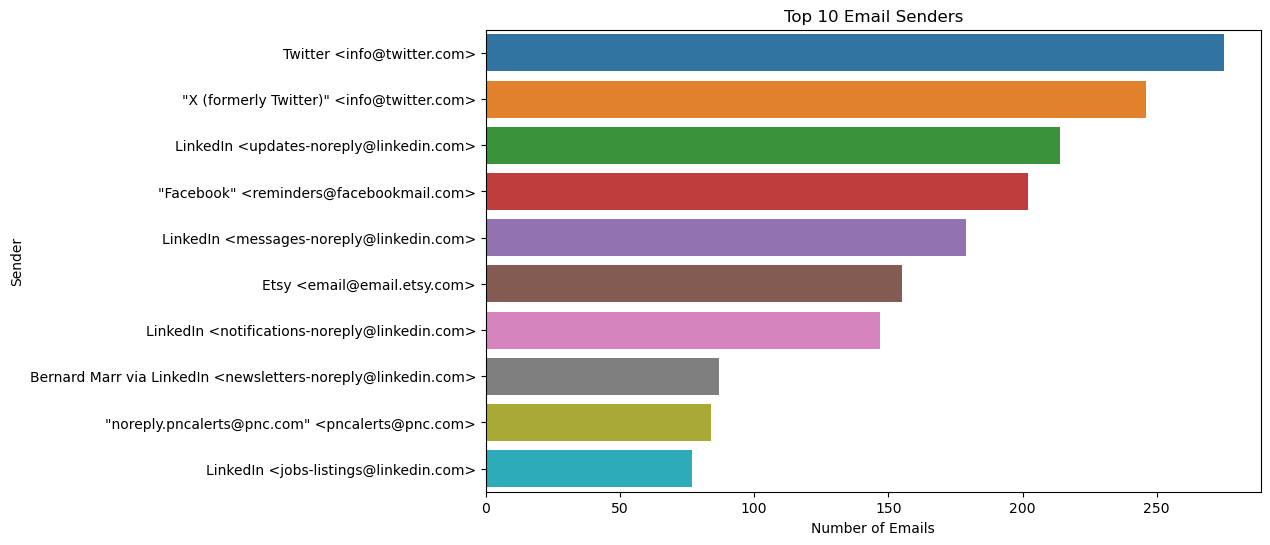

In [109]:
# Top 10 senders
top_senders = pdf['sender'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_senders.values, y=top_senders.index)
plt.title('Top 10 Email Senders')
plt.xlabel('Number of Emails')
plt.ylabel('Sender')
plt.show()

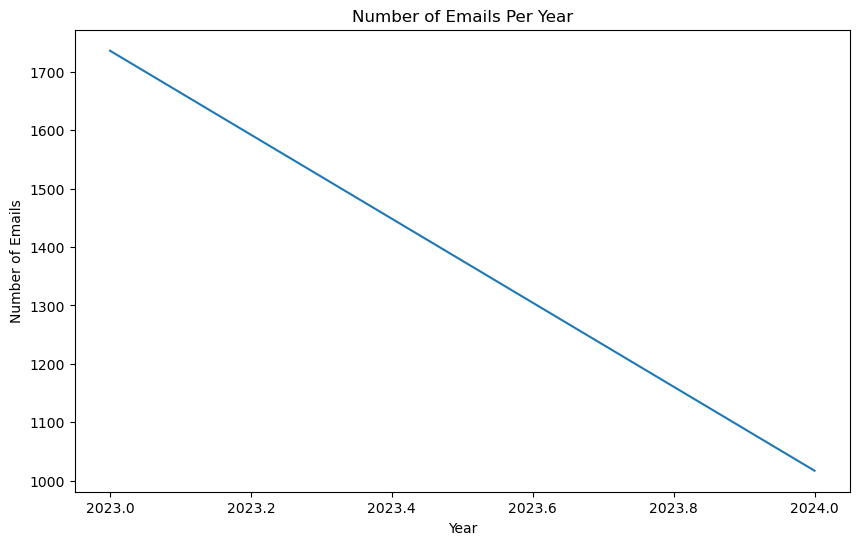

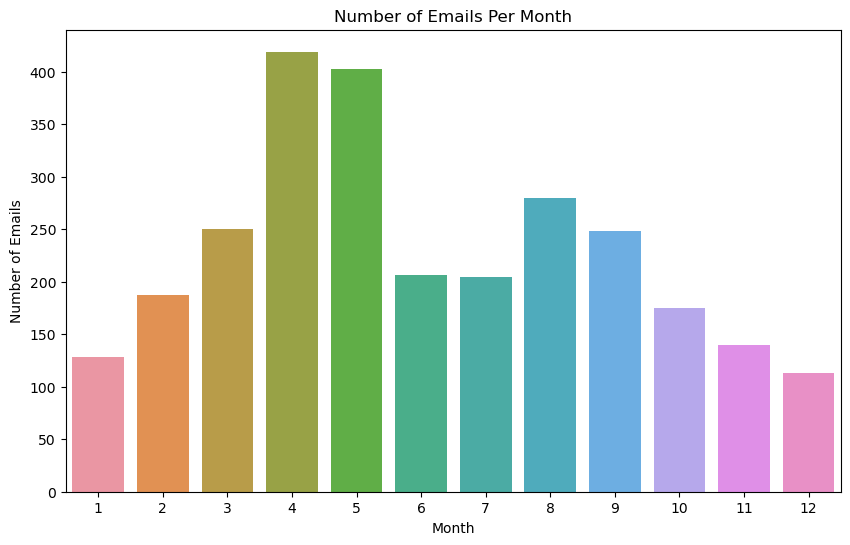

In [110]:
# Count emails by year
emails_by_year = pdf['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=emails_by_year.index, y=emails_by_year.values)
plt.title('Number of Emails Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.show()

# Count emails by month
emails_by_month = pdf['month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=emails_by_month.index, y=emails_by_month.values)
plt.title('Number of Emails Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Emails')
plt.show()


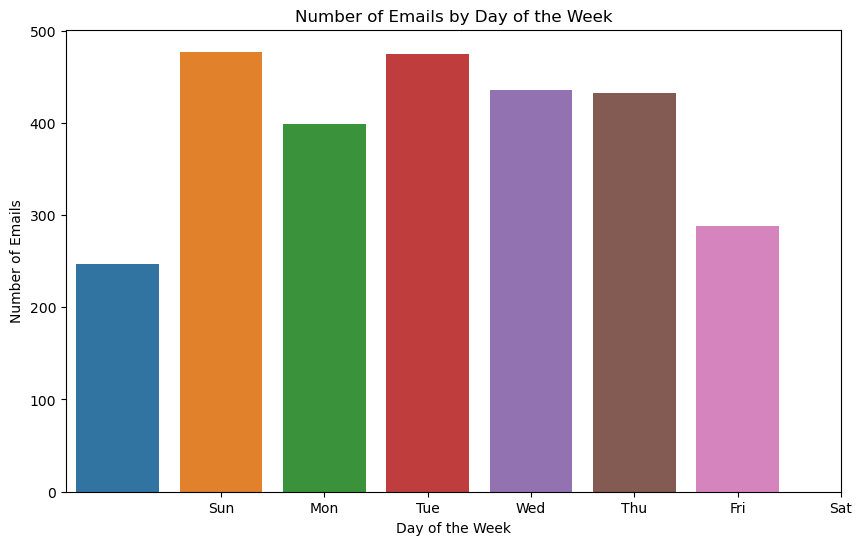

In [111]:
# Count emails by day of the week
emails_by_day_of_week = pdf['day_of_week'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=emails_by_day_of_week.index, y=emails_by_day_of_week.values)
plt.title('Number of Emails by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Emails')
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7], labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()


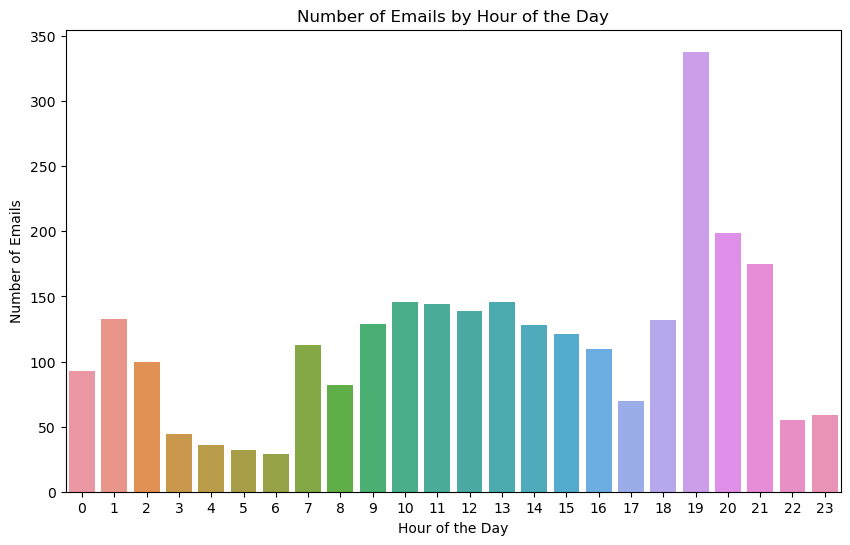

In [112]:
# Count emails by hour of the day
emails_by_hour = pdf['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=emails_by_hour.index, y=emails_by_hour.values)
plt.title('Number of Emails by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Emails')
plt.show()


# Data Processing

In [1]:
from pyspark.sql import SparkSession

In [5]:
# Initialize Spark session
try:
    spark = SparkSession.builder \
        .appName("Postgres to Spark DataFrame") \
        .config("spark.jars", jdbc_driver_path) \
        .getOrCreate()
except Exception as e:
    raise

NameError: name 'jdbc_driver_path' is not defined

In [118]:
# PostgreSQL connection properties
jdbc_url = "jdbc:postgresql://localhost:5432/ainbox"  # Update with your actual JDBC URL
table = "emails"  # Update with your actual table name
properties = {
    "user": "postgres",
    "password": "xxxxxxx",
    "driver": "org.postgresql.Driver"
}

In [129]:
# Read data from PostgreSQL table into a Spark DataFrame
try:
    df = spark.read.jdbc(url=jdbc_url, table=table, properties=properties)
    logger.info("Data read successfully from PostgreSQL.")
except Exception as e:
    logger.error(f"Error reading data from PostgreSQL: {e}")
    raise

INFO:__main__:Data read successfully from PostgreSQL.


In [132]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, udf, length, year, month, dayofmonth, hour
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from nltk.corpus import stopwords
import re

# Preprocessing Functions
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = text.lower()  # Convert to lowercase
    tokens = re.findall(r'\b\w+\b', text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(tokens)

preprocess_text_udf = udf(preprocess_text, StringType())

df = df.withColumn("cleaned_body", preprocess_text_udf(col("body_plain")))

# Extract time-related features
df = df.withColumn("year", year("date"))
df = df.withColumn("month", month("date"))
df = df.withColumn("day", dayofmonth("date"))
df = df.withColumn("hour", hour("date"))

# Calculate the length of the email body
df = df.withColumn("body_length", length("body_plain"))

# Ensure there are no null values in essential columns
df = df.na.drop(subset=["cleaned_body", "date"])

# Tokenize the cleaned email body
tokenizer = Tokenizer(inputCol="cleaned_body", outputCol="words")

# Apply HashingTF
hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=10000)

# Apply IDF
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")

# Vector assembler to combine all features
assembler = VectorAssembler(inputCols=["tfidf_features", "year", "month", "day", "hour", "body_length"], outputCol="features")

# Create and apply the pipeline
pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf, assembler])
model = pipeline.fit(df)
processed_df = model.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(processed_df)
scaled_df = scaler_model.transform(processed_df)

# Display the processed DataFrame
scaled_df.select("scaled_features").show(10, truncate=False)

Py4JJavaError: An error occurred while calling o759.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 43.0 failed 1 times, most recent failure: Lost task 0.0 in stage 43.0 (TID 33) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1570)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:695)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:660)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:636)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:582)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:541)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 50 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1202)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1289)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1256)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1242)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1242)
	at org.apache.spark.mllib.feature.IDF.fit(IDF.scala:55)
	at org.apache.spark.ml.feature.IDF.fit(IDF.scala:93)
	at org.apache.spark.ml.feature.IDF.fit(IDF.scala:69)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:103)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1570)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:54)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:695)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:660)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:636)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:582)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:541)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 50 more


In [ ]:
# Train KMeans model
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="scaled_features", k=5)
model = kmeans.fit(scaled_df)
predictions = model.transform(scaled_df)

# Show clustering results
predictions.select("email_id", "prediction").show(10)